In [1]:
import sklearn
import skimage
import numpy as np
import scipy
import pandas as pd
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
%matplotlib inline

# 1.
## (a)

In [2]:
# I Read the data with pandas
amazon_review = pd.read_table("./sentiment labelled sentences/amazon_cells_labelled.txt", header = None)
yelp_review = pd.read_table("./sentiment labelled sentences/yelp_labelled.txt", header = None)

In [3]:
# Pandas does not read imdb dataset correctly because of "
# Read it the old fasion way
imdb_raw = []
f = open("./sentiment labelled sentences/imdb_labelled.txt")
line = f.readline()
while line:
    imdb_raw.append(line)
    line = f.readline()
f.close()
# Cleaning the text
imdb_raw = np.array([x.strip("\n").split("\t") for x in imdb_raw])
# Put into pandas
imdb_review = pd.DataFrame(imdb_raw)
# Convert to int
imdb_review.loc[:,1] = pd.to_numeric(imdb_review.loc[:,1])
# Preview the data set, so we know first column is the review, and the second column is the label
imdb_review.head(3)

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0


In [4]:
# Preview the data set, so we know first column is the review, and the second column is the label
amazon_review.head(3)

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1


In [5]:
# Checking the total number of reviews of each data set
amazon_review.shape, yelp_review.shape, imdb_review.shape

((1000, 2), (1000, 2), (1000, 2))

### Checking if the labels are balanced for each dataset, total number of 1's divide over the total number of reviews
Score is either 1 (for positive) or 0 (for negative)

In [6]:
print("The percentage of positive reivews for amazon dataset is", sum(amazon_review[1])/amazon_review[1].size)
print("The percentage of positive reivews for yelp dataset is", sum(yelp_review[1])/yelp_review[1].size)
print("The percentage of positive reivews for imdb dataset is", sum(imdb_review[1])/imdb_review[1].size)

The percentage of positive reivews for amazon dataset is 0.5
The percentage of positive reivews for yelp dataset is 0.5
The percentage of positive reivews for imdb dataset is 0.5


### So the labels are balanced, 50/50 for positive and negative reviews for all amazon, yelp dataset and Imdb dataset. Therefore the ratio of labels for these dataset are 1 to 1, which means half the dataset are labelled positive and half are negative as said in the readme text.

In [7]:
# Now I put them into numpy arrays to be better processed later
amazon_data = amazon_review[0].values
yelp_data = yelp_review[0].values
imdb_data = imdb_review[0].values
# Store labels in seperate array
amazon_labels = amazon_review[1].values
yelp_labels = yelp_review[1].values
imdb_labels = imdb_review[1].values

## (b)
### Lowercase all of the words because the only case if we want to see the uppercase, is when we want to determine the degree of positiveness or negativeness of the review. Uppercase might imply more extreme. However in our case, we only want to determine if positive or negative. So it is better to lowercase all the words for better grouping of the words.

In [8]:
def set_lower(dataset):
    return [x.lower() for x in dataset]

### Lemmatization of all the words because the tense of the word does not depend on if the review is positive or negative

In [9]:
def stem(dataset):
    stemmer = LancasterStemmer()
    return [stemmer.stem(x) for x in dataset]

### Strip punctuation since there are no punctuations to resemble a positive or negative review. Any punctuation can go both ways for the labels

In [10]:
def strip_punc(dataset):
    translate_key = str.maketrans('', '', string.punctuation)
    return [x.translate(translate_key) for x in dataset]

### Split the sentences by "space" of the reviews into list of list of words, this way it is better to keep preprocessing and to use for models

In [11]:
def split_review(dataset):
    return [x.split(" ") for x in dataset]

### Strip the stop words except for the turning transitional stop words and negation words (anything with 't in the end)
Using stop words in nltk.corpus. But do not remove any word with 't in the end, and do not remove "against", "no", "nor", "not", "until"

In [12]:
def remove_stop(dataset):
    stop_words = list(set(stopwords.words("English")))
    # Do not remove negation words
    stop_words = [x for x in stop_words if x[-2:] != "'t"]
    # Do not remove "against", "nor", "not", "until"
    stop_words = [x for x in stop_words if x not in ["against", "no", "nor", "not", "until"]]
    
    removed_dataset = []
    for review in dataset:
        removed_dataset.append(([word for word in review if word not in stop_words]))
    return removed_dataset

### Remove all the numbers, most numbers do not have direct effect on the review being positive or negative
except for 10, when people say "I'm giving it a 10", therefore we keep the "10"s

In [13]:
def remove_numbers(dataset):
    removed_dataset = []
    for review in dataset:
        removed_dataset.append(([word for word in review if word.isalpha() or word == "10"]))
    return removed_dataset

### Put all the preprocessing functions above into a pipeline to run all three datasets

In [14]:
def preprocessing_pipe(dataset):
    new_dataset = set_lower(dataset)
    new_dataset = stem(new_dataset)
    new_dataset = strip_punc(new_dataset)
    new_dataset = split_review(new_dataset)
    new_dataset = remove_stop(new_dataset)
    new_dataset = remove_numbers(new_dataset)
    return np.array(new_dataset)

In [15]:
amazon_data_clean = preprocessing_pipe(amazon_data)
yelp_data_clean = preprocessing_pipe(yelp_data)
imdb_data_clean = preprocessing_pipe(imdb_data)

## (c)
### Split training and testing set

In [16]:
# Split first 400 positive and 400 negative reviews as training data, and next 100 as testing data
amazon_train_index = np.array(np.where(amazon_labels == 1)[0][:400].tolist() + np.where(amazon_labels == 0)[0][:400].tolist())
train_amazon_data, train_amazon_labels = amazon_data_clean[amazon_train_index], amazon_labels[amazon_train_index]

amazon_test_index = np.array(np.where(amazon_labels == 1)[0][400:].tolist() + np.where(amazon_labels == 0)[0][400:].tolist())
test_amazon_data, test_amazon_labels = amazon_data_clean[amazon_test_index], amazon_labels[amazon_test_index]

yelp_train_index = np.array(np.where(yelp_labels == 1)[0][:400].tolist() + np.where(yelp_labels == 0)[0][:400].tolist())
train_yelp_data, train_yelp_labels = yelp_data_clean[yelp_train_index], yelp_labels[yelp_train_index]

yelp_test_index = np.array(np.where(yelp_labels == 1)[0][400:].tolist() + np.where(yelp_labels == 0)[0][400:].tolist())
test_yelp_data, test_yelp_labels = yelp_data_clean[yelp_test_index], yelp_labels[yelp_test_index]

imdb_train_index = np.array(np.where(imdb_labels == 1)[0][:400].tolist() + np.where(imdb_labels == 0)[0][:400].tolist())
train_imdb_data, train_imdb_labels = imdb_data_clean[imdb_train_index], imdb_labels[imdb_train_index]

imdb_test_index = np.array(np.where(imdb_labels == 1)[0][400:].tolist() + np.where(imdb_labels == 0)[0][400:].tolist())
test_imdb_data, test_imdb_labels = imdb_data_clean[imdb_test_index], imdb_labels[imdb_test_index]

In [17]:
# Put all three datasets of training data and labels together
train_data = np.concatenate((train_amazon_data, train_yelp_data, train_imdb_data), axis = 0)
train_labels = np.concatenate((train_amazon_labels, train_yelp_labels), axis = 0)
train_labels = np.concatenate((train_labels, train_imdb_labels), axis = 0)

# Put all three datasets of testing data and labels together
test_data = np.concatenate((test_amazon_data, test_yelp_data, test_imdb_data), axis = 0)
test_labels = np.concatenate((test_amazon_labels, test_yelp_labels), axis = 0)
test_labels = np.concatenate((test_labels, test_imdb_labels), axis = 0)

Checking the labels ratio of both training and testing set

In [18]:
print("The ratio of positive:negative reviews for training dataset is",
      sum(train_labels)/(len(train_labels) - sum(train_labels)))
print("The ratio of positive:negative reviews for testing dataset is",
      sum(test_labels)/(len(test_labels) - sum(test_labels)))

The ratio of positive:negative reviews for training dataset is 1.0
The ratio of positive:negative reviews for testing dataset is 1.0


As long as the ratio of the training set and teseting set is 1, so we have done it correctly

### (d)
We cannot use the testing set to create feature vectors because it would be overfitting te testing set as well. We should not know what is in the testing set beforehand, so we cannot train the model with features vectors gathered from the testing set. It would not really be a testing set anymore if we do so.

In [19]:
# First we gather all the feature vectors from testing set
# A function to build a dictionary of unique words
def grab_feature(data_set):
    feature_list = []
    for review in data_set:
        for word in review:
            if word not in feature_list:
                feature_list.append(word)
    return np.array(feature_list)
        
feature_vector = grab_feature(train_data)

In [20]:
print("There are", len(feature_vector), "unique words for our feature vector")

There are 4484 unique words for our feature vector


In [21]:
# Function to count occurances in whole data sets, 1 for positive, 0 for negative, 99 for including both
def count_occ(data_set, data_labels, feature_vec, positive = 99):
    count_list = np.zeros(len(feature_vec))
    for i in range(len(data_set)):
        if data_labels[i] == positive:
            for word in data_set[i]:
                if word in feature_vec:
                    count_list[np.where(feature_vec == word)[0][0]] += 1
        elif (positive == 99):
            for word in data_set[i]:
                if word in feature_vec:
                    count_list[np.where(feature_vec == word)[0][0]] += 1
    return count_list

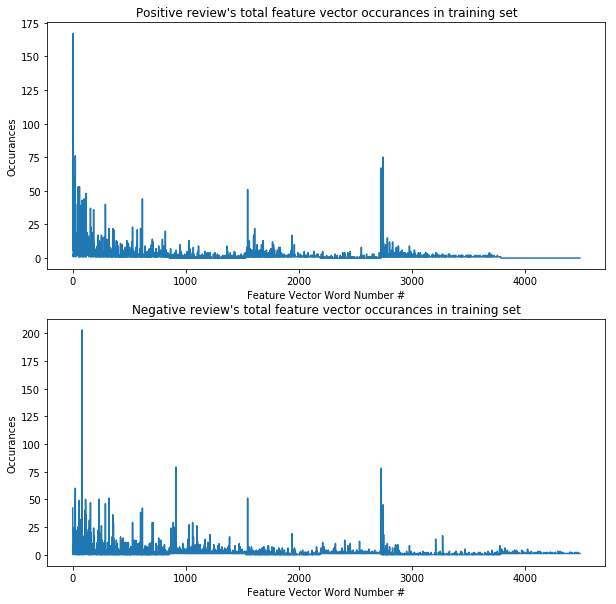

In [22]:
# Count up occurance in training set, 1 for positive and 0 for negative reviews
train_positive_count = count_occ(train_data, train_labels, feature_vector, 1)
train_negative_count = count_occ(train_data, train_labels, feature_vector, 0)
# Plot out the positive and negative review feature vectors

fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(2,1,1)
plt.plot(train_positive_count)
axes.title.set_text("Positive review's total feature vector occurances in training set")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances")

axes = fig.add_subplot(2,1,2)
plt.plot(train_negative_count)
axes.title.set_text("Negative review's total feature vector occurances in training set")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances")

In [23]:
# The bag of words function we wrote to count up the feature vectors of a review
def bag_of_words(review_data, feature_vec):
    feature_vec_count = np.zeros(len(feature_vec))
    for i in range(0, len(feature_vec)):
        feature_vec_count[i] = review_data.count(feature_vec[i])
    return feature_vec_count

#### Run the bag of words method without doing any postprocessing first for all reviews in training and testing set

In [24]:
# For the training set
train_feature_vecs = []
for j in range(len(train_data)):
    train_feature_vecs.append(bag_of_words(train_data[j], feature_vector))

# For the testing set
test_feature_vecs = []
for j in range(len(test_data)):
    test_feature_vecs.append(bag_of_words(test_data[j], feature_vector))

In [25]:
# Occurance in training set
train_count = count_occ(train_data, train_labels, feature_vector, 99)
# Occurance in testing set
test_count = count_occ(test_data, test_labels, feature_vector, 99)

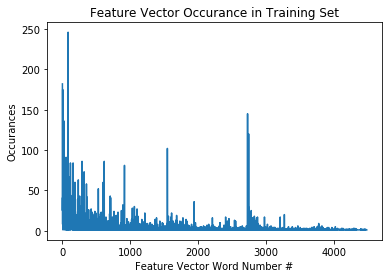

In [26]:
_ = plt.plot(train_count)
_ = plt.title("Feature Vector Occurance in Training Set")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances")

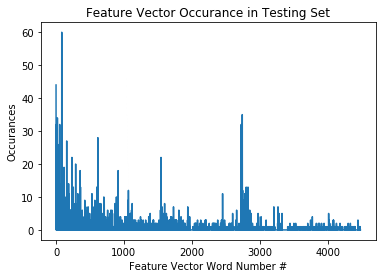

In [27]:
_ = plt.plot(test_count)
_ = plt.title("Feature Vector Occurance in Testing Set")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances")

### From the histograms above, one can see that a lot of the words in the feature vector had very little occurances in both the training and testing review data sets

#### Here we output feature vectors of two reviews in the training set

In [28]:
np.set_printoptions(threshold = sys.maxsize)

In [29]:
# For training data #55
bag_55 = bag_of_words(train_data[55], feature_vector)
bag_55

array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

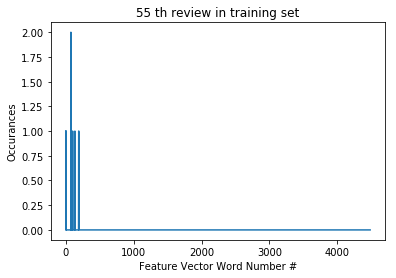

In [30]:
_ = plt.plot(bag_55)
_ = plt.title("55 th review in training set")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances")

In [31]:
# For training data #555
bag_555 = bag_of_words(train_data[555], feature_vector)
bag_555

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

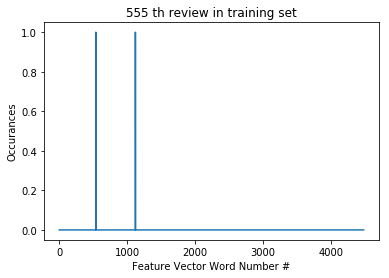

In [32]:
_ = plt.plot(bag_555)
_ = plt.title("555 th review in training set")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances")

In [33]:
np.set_printoptions(threshold=20)

## (e)

### Trying log-normalization. For each element of the feature vector x, transform it into f (x) = log (x + 1).

In [34]:
def log_normalization(x):
    return np.log(x + 1)

In [35]:
log_normal_train = np.array(list(map(log_normalization, train_feature_vecs)))

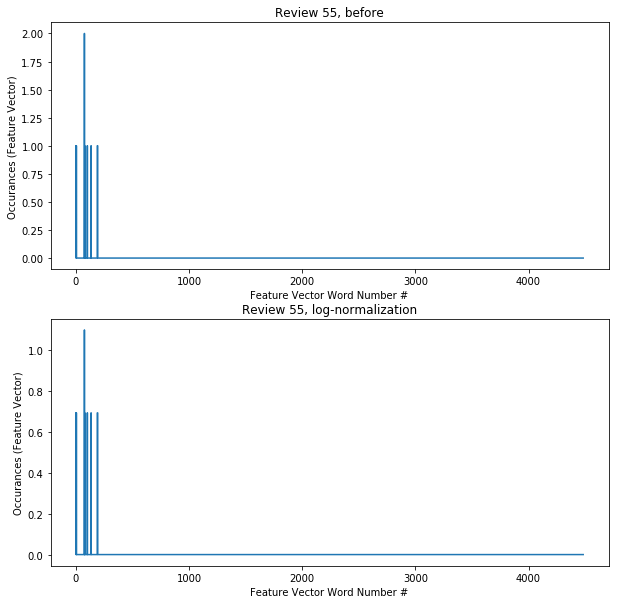

In [36]:
# Observing the changes for one review
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(2,1,1)
plt.plot(bag_55)
axes.title.set_text("Review 55, before")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

# Observing the changes for all reviews in the training set
axes = fig.add_subplot(2,1,2)
plt.plot(log_normal_train[55])
axes.title.set_text("Review 55, log-normalization")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

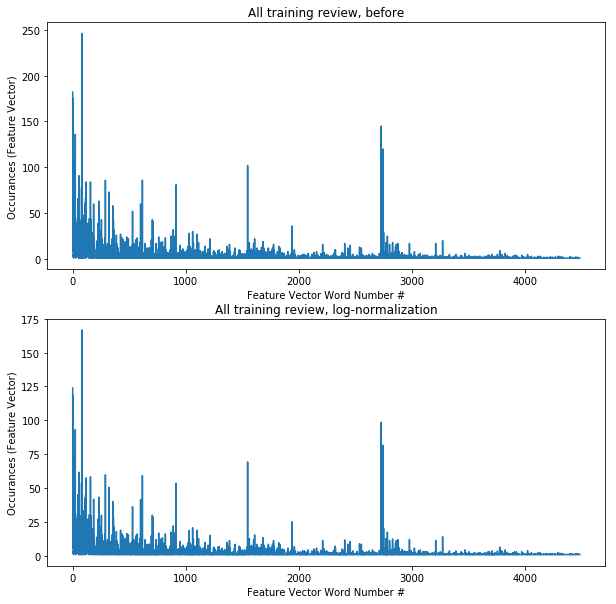

In [37]:
# Observing the changes for one review
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(2,1,1)
plt.plot(train_count)
axes.title.set_text("All training review, before")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

# Observing the changes for all reviews in the training set
axes = fig.add_subplot(2,1,2)
plt.plot(sum(log_normal_train))
axes.title.set_text("All training review, log-normalization")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

### Trying l1 normalization. Normalize the l1 norm of the feature vector

In [38]:
l1_normal_train = sklearn.preprocessing.normalize(train_feature_vecs, "l1")

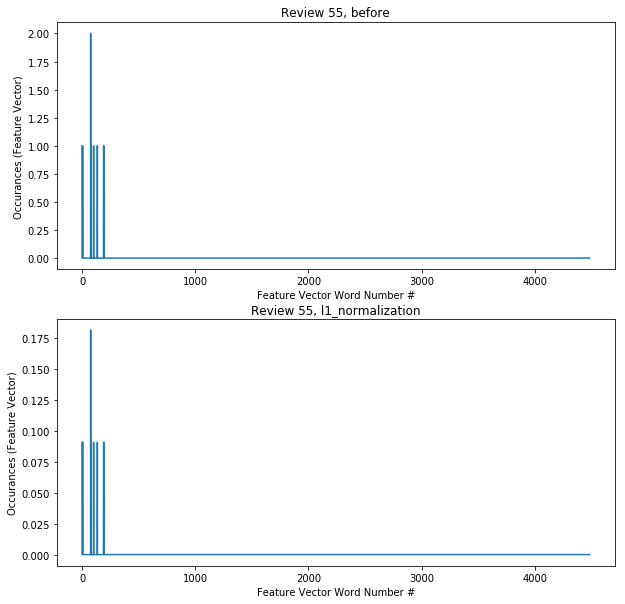

In [39]:
# Observing the changes for one review
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(2,1,1)
plt.plot(bag_55)
axes.title.set_text("Review 55, before")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

# Observing the changes for all reviews in the training set
axes = fig.add_subplot(2,1,2)
plt.plot(l1_normal_train[55])
axes.title.set_text("Review 55, l1_normalization")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

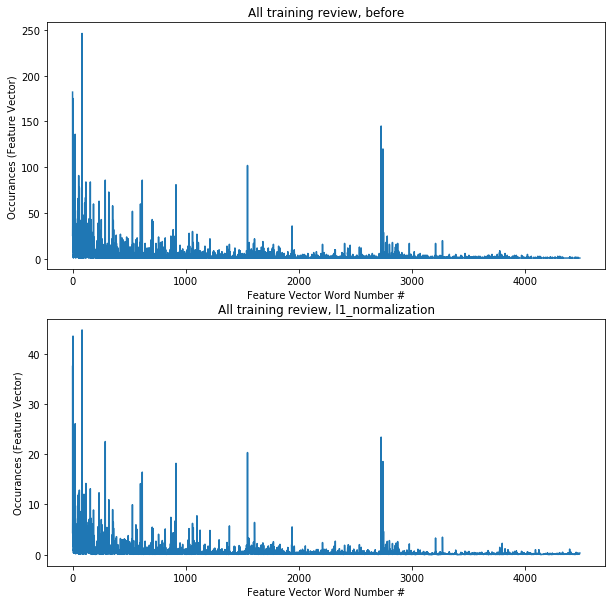

In [40]:
# Observing the changes for one review
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(2,1,1)
plt.plot(train_count)
axes.title.set_text("All training review, before")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

# Observing the changes for all reviews in the training set
axes = fig.add_subplot(2,1,2)
plt.plot(sum(l1_normal_train))
axes.title.set_text("All training review, l1_normalization")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

### l2 normalization. Normalize the l2 norm of the feature vector

In [41]:
l2_normal_train = sklearn.preprocessing.normalize(train_feature_vecs, "l2")

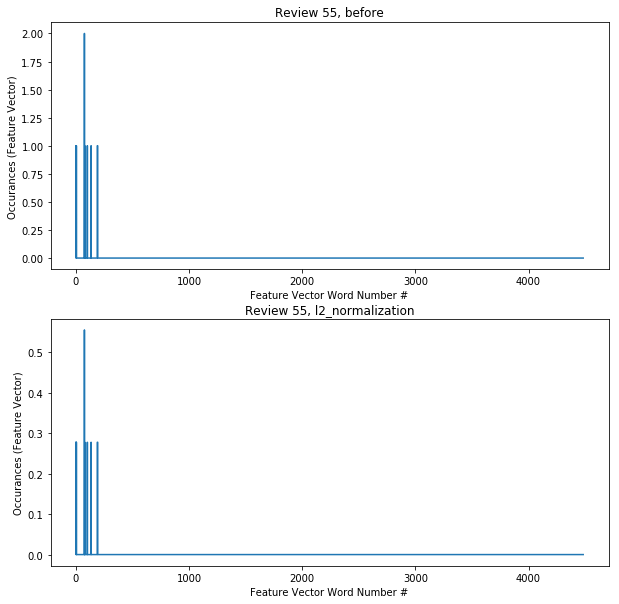

In [42]:
# Observing the changes for one review
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(2,1,1)
plt.plot(bag_55)
axes.title.set_text("Review 55, before")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

# Observing the changes for all reviews in the training set
axes = fig.add_subplot(2,1,2)
plt.plot(l2_normal_train[55])
axes.title.set_text("Review 55, l2_normalization")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

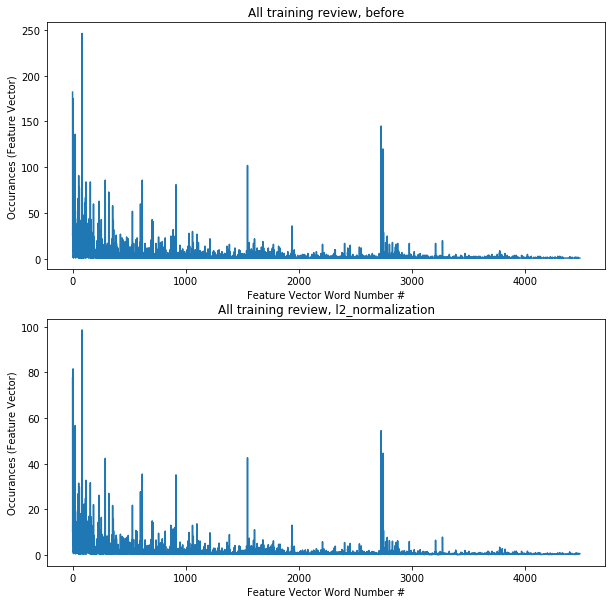

In [43]:
# Observing the changes for one review
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(2,1,1)
plt.plot(train_count)
axes.title.set_text("All training review, before")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

# Observing the changes for all reviews in the training set
axes = fig.add_subplot(2,1,2)
plt.plot(sum(l2_normal_train))
axes.title.set_text("All training review, l2_normalization")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

### Standardize the data by subtracting the mean and dividing by the variance

In [44]:
standardizer = sklearn.preprocessing.StandardScaler()
standardizer.fit(train_feature_vecs)
standardized_train = standardizer.transform(train_feature_vecs)

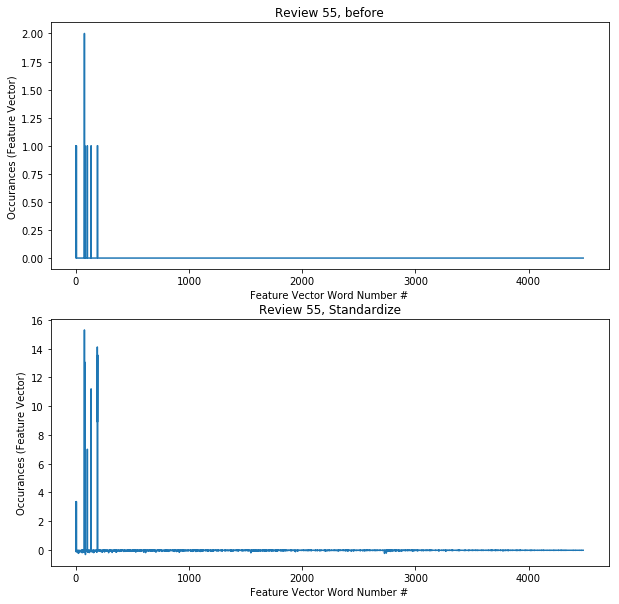

In [45]:
# Observing the changes for one review
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(2,1,1)
plt.plot(bag_55)
axes.title.set_text("Review 55, before")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

# Observing the changes for all reviews in the training set
axes = fig.add_subplot(2,1,2)
plt.plot(standardized_train[55])
axes.title.set_text("Review 55, Standardize")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

In [46]:
standardized_train[55]

array([ 3.33590038, -0.10259784, -0.12299563, ..., -0.02041667,
       -0.02041667, -0.02041667])

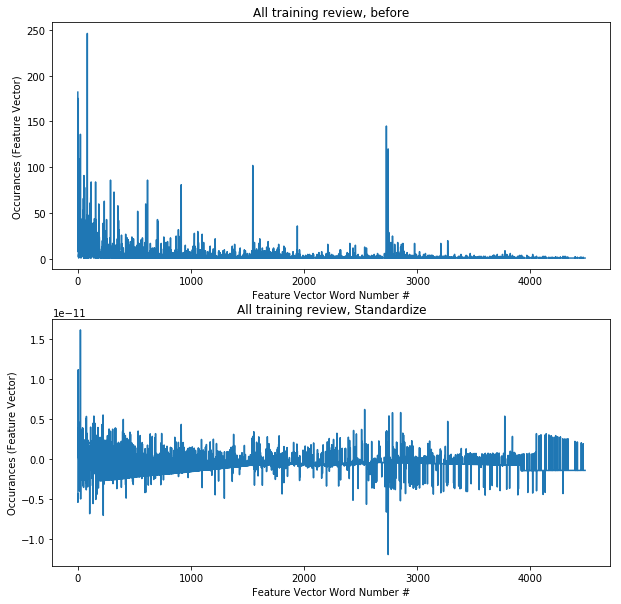

In [47]:
# Observing the changes for one review
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(2,1,1)
plt.plot(train_count)
axes.title.set_text("All training review, before")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

# Observing the changes for all reviews in the training set
axes = fig.add_subplot(2,1,2)
plt.plot(sum(standardized_train))
axes.title.set_text("All training review, Standardize")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

### The L2 normalization keeps the 0 elements still 0 in feature vector while decreasing variance the most in all the postprocessing strategies. So we will be trying L2 Norm for postprocessing strategy, and it proved to have the highest testing accuracy in part (f) out of all the strategies.

## (f)

### Logistic Regression

In [48]:
# Using logistic regression
lg = LogisticRegression(solver='lbfgs', max_iter = 5000)
lg.fit(l2_normal_train, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:
l2_test = sklearn.preprocessing.normalize(test_feature_vecs, "l2")
lg_res_test = lg.predict(l2_test)
lg_res_training = lg.predict(l2_normal_train)

In [50]:
print("Logistic Regression classification accuracy on training set is", sum(lg_res_training == train_labels)/len(train_labels))
print("Logistic Regression classification accuracy on test set is", sum(lg_res_test == test_labels)/len(test_labels))

Logistic Regression classification accuracy on training set is 0.93375
Logistic Regression classification accuracy on test set is 0.8133333333333334


In [51]:
pd.DataFrame(metrics.confusion_matrix(test_labels, lg_res_test))

,0,1
0,257,43
1,69,231


In [52]:
# Looking at weight of logistic regression
lg_weight = lg.coef_
# Get top 20 "positive" weighted words meaning classify as 1 (positive review)
feature_vector[np.argsort(-lg_weight)[0][:20]]

array(['great', 'good', 'love', 'excellent', 'nice', 'delicious', 'best',
       'loved', 'fantastic', 'works', 'amazing', 'awesome', 'friendly',
       'funny', 'happy', 'liked', 'well', 'beautiful', 'wonderful',
       'comfortable'], dtype='<U33')

In [53]:
# Get top 20 "negative" weighted words meaning classify as 0 (negative review)
feature_vector[np.argsort(lg_weight)[0][:20]]

array(['not', 'bad', 'poor', 'worst', 'didnt', 'terrible', 'awful', 'no',
       'minutes', 'dont', 'horrible', 'waste', 'nothing',
       'disappointment', 'disappointing', 'never', 'slow', 'stupid',
       'piece', 'avoid'], dtype='<U33')

### Naive Bayes classifier

In [54]:
nb = BernoulliNB()
nb.fit(l2_normal_train, train_labels)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [55]:
nb_res_test = nb.predict(l2_test)
nb_res_training = nb.predict(l2_normal_train)

In [56]:
print("Naive Bayes classification accuracy on training set is", sum(nb_res_training == train_labels)/len(train_labels))
print("Naive Bayes classification accuracy on test set is", sum(nb_res_test == test_labels)/len(test_labels))

Naive Bayes classification accuracy on training set is 0.9525
Naive Bayes classification accuracy on test set is 0.8216666666666667


In [57]:
pd.DataFrame(metrics.confusion_matrix(test_labels, nb_res_test))

,0,1
0,261,39
1,68,232


## (g)
### N-gram model

In [58]:
def combine_n_gram(dataset, n):
    new_dataset = []
    for review in dataset:
        new_review = []
        for i in range(len(review) - (n - 1)):
            for j in range(n - 1):
                new_review.append(review[i + j] + " " + review[i + j + 1])
        new_dataset.append(new_review)
    return new_dataset

In [59]:
# Make dataset into 2 grams
n_gram_train_data = combine_n_gram(train_data, 2)
n_gram_test_data = combine_n_gram(test_data, 2)
print(n_gram_train_data[55])

['love headset', 'headset bluetooth', 'bluetooth headset', 'headset great', 'great reception', 'reception good', 'good ear', 'ear piece', 'piece comfortable', 'comfortable fit']


In [60]:
# Grab new feature vector
n_gram_feature_vector = grab_feature(n_gram_train_data)

# For the training set
n_gram_train_feature_vecs = []
for j in range(len(train_data)):
    n_gram_train_feature_vecs.append(bag_of_words(n_gram_train_data[j], n_gram_feature_vector))

# For the testing set
n_gram_test_feature_vecs = []
for j in range(len(n_gram_test_data)):
    n_gram_test_feature_vecs.append(bag_of_words(n_gram_test_data[j], n_gram_feature_vector))

In [61]:
# Use the same L2 normalization post processing
n_gram_l2_normal_train = sklearn.preprocessing.normalize(n_gram_train_feature_vecs, "l2")
n_gram_l2_normal_test = sklearn.preprocessing.normalize(n_gram_test_feature_vecs, "l2")

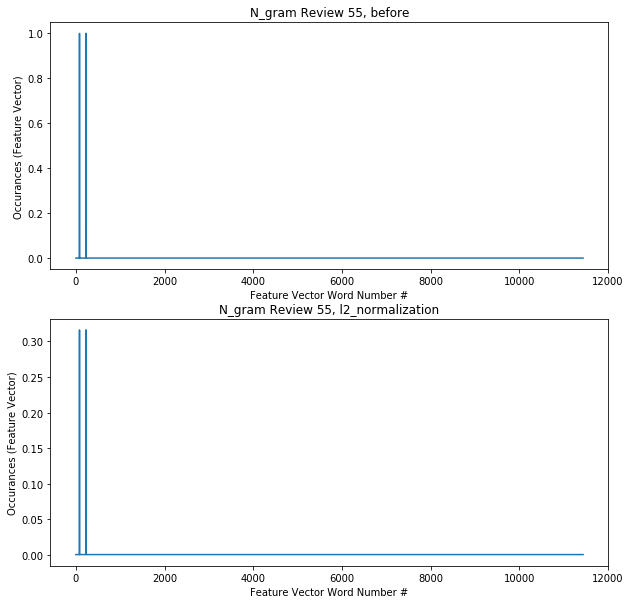

In [62]:
# Observing the changes for one review
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(2,1,1)
plt.plot(n_gram_train_feature_vecs[55])
axes.title.set_text("N_gram Review 55, before")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

# Observing the changes for all reviews in the training set
axes = fig.add_subplot(2,1,2)
plt.plot(n_gram_l2_normal_train[55])
axes.title.set_text("N_gram Review 55, l2_normalization")
_ = plt.xlabel("Feature Vector Word Number #")
_ = plt.ylabel("Occurances (Feature Vector)")

### Logistic Regression

In [63]:
# Using logistic regression
lg_n = LogisticRegression(solver='lbfgs', max_iter = 5000)
lg_n.fit(n_gram_l2_normal_train, train_labels)
lg_n_res_test = lg_n.predict(n_gram_l2_normal_test)
lg_n_res_training = lg_n.predict(n_gram_l2_normal_train)
print("Logistic Regression classification accuracy on training set is", sum(lg_n_res_training == train_labels)/len(train_labels))
print("Logistic Regression classification accuracy on test set is", sum(lg_n_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, lg_n_res_test))

Logistic Regression classification accuracy on training set is 0.98125
Logistic Regression classification accuracy on test set is 0.625


,0,1
0,106,194
1,31,269


In [64]:
# Looking at weight of logistic regression
lg_n_weight = lg_n.coef_
# Get top 20 "positive" weighted words meaning classify as 1 (positive review)
n_gram_feature_vector[np.argsort(-lg_n_weight)[0][:20]]

array(['works great', 'highly recommend', 'one best', 'great phone',
       'great product', 'food good', 'easy use', 'great food',
       'really good', 'would recommend', 'works well', 'great service',
       'food delicious', 'love phone', 'highly recommended',
       'good product', 'friendly staff', 'well made', 'pretty good',
       'film great'], dtype='<U41')

In [65]:
# Get top 20 "negative" weighted words meaning classify as 0 (negative review)
n_gram_feature_vector[np.argsort(lg_n_weight)[0][:20]]

array(['not good', 'would not', 'waste time', 'not work', 'dont waste',
       'dont buy', 'not impressed', 'customer service', 'not worth',
       'im not', 'wont back', 'no plot', 'not recommend', 'poor quality',
       'waste money', 'piece junk', 'not like', 'stay away', 'not fit',
       'dont think'], dtype='<U41')

### Naive Bayes classifier

In [66]:
# Using Naive Bayes
nb_n = BernoulliNB()
nb_n.fit(n_gram_l2_normal_train, train_labels)
nb_n_res_test = nb_n.predict(n_gram_l2_normal_test)
nb_n_res_training = nb_n.predict(n_gram_l2_normal_train)
print("Naive Bayes classification accuracy on training set is", sum(nb_n_res_training == train_labels)/len(train_labels))
print("Naive Bayes classification accuracy on test set is", sum(nb_n_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, nb_n_res_test))

Naive Bayes classification accuracy on training set is 0.9820833333333333
Naive Bayes classification accuracy on test set is 0.6366666666666667


,0,1
0,106,194
1,24,276


## (h)
### PCA

In [67]:
def PCA(n_comp, training_vectors, testing_vectors):
    # Remove x mean from x
    training_vectors_centered = np.array(training_vectors) - np.array(training_vectors).mean(0)
    testing_vectors_centered = np.array(testing_vectors) - np.array(training_vectors).mean(0)
    u, s, v = np.linalg.svd(training_vectors_centered, full_matrices = 0)
    eigen_value, eigen_vector = np.diag(s), v
    return np.dot(eigen_vector[:n_comp], training_vectors_centered.T).T, np.dot(eigen_vector[:n_comp], testing_vectors_centered.T).T


### Bag of words

#### n_components = 10

In [68]:
# Performing PCAfor dimension of features for 10
pca_train_feature_vecs_10, pca_test_feature_vecs_10 = PCA(10, l2_normal_train, l2_test)

# Using logistic regression for dimension of features for 10
new_lg_10 = LogisticRegression(solver='lbfgs', max_iter = 5000)
new_lg_10.fit(pca_train_feature_vecs_10, train_labels)
new_lg_10_res_test = new_lg_10.predict(pca_test_feature_vecs_10)
new_lg_10_res_training = new_lg_10.predict(pca_train_feature_vecs_10)
print("Logistic Regression classification accuracy on training set is", sum(new_lg_10_res_training == train_labels)/len(train_labels))
print("Logistic Regression classification accuracy on test set is", sum(new_lg_10_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, new_lg_10_res_test))

Logistic Regression classification accuracy on training set is 0.65125
Logistic Regression classification accuracy on test set is 0.6766666666666666


,0,1
0,215,85
1,109,191


In [69]:
# Using Naive Bayes for dimension of features for 10
new_nb_10 = BernoulliNB()
new_nb_10.fit(pca_train_feature_vecs_10, train_labels)
new_nb_10_res_test = new_nb_10.predict(pca_test_feature_vecs_10)
new_nb_10_res_training = new_nb_10.predict(pca_train_feature_vecs_10)
print("Naive Bayes classification accuracy on training set is", sum(new_nb_10_res_training == train_labels)/len(train_labels))
print("Naive Bayes classification accuracy on test set is", sum(new_nb_10_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, new_nb_10_res_test))

Naive Bayes classification accuracy on training set is 0.5941666666666666
Naive Bayes classification accuracy on test set is 0.6083333333333333


,0,1
0,220,80
1,155,145


#### n_components = 50

In [70]:
# Performing PCAfor dimension of features for 50
pca_train_feature_vecs_50, pca_test_feature_vecs_50 = PCA(50, l2_normal_train, l2_test)

# Using logistic regression for dimension of features for 50
new_lg_50 = LogisticRegression(solver='lbfgs', max_iter = 5000)
new_lg_50.fit(pca_train_feature_vecs_50, train_labels)
new_lg_50_res_test = new_lg_50.predict(pca_test_feature_vecs_50)
new_lg_50_res_training = new_lg_50.predict(pca_train_feature_vecs_50)
print("Logistic Regression classification accuracy on training set is", sum(new_lg_50_res_training == train_labels)/len(train_labels))
print("Logistic Regression classification accuracy on test set is", sum(new_lg_50_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, new_lg_50_res_test))

Logistic Regression classification accuracy on training set is 0.7375
Logistic Regression classification accuracy on test set is 0.6866666666666666


,0,1
0,234,66
1,122,178


In [71]:
# Using Naive Bayes for dimension of features for 50
new_nb_50 = BernoulliNB()
new_nb_50.fit(pca_train_feature_vecs_50, train_labels)
new_nb_50_res_test = new_nb_50.predict(pca_test_feature_vecs_50)
new_nb_50_res_training = new_nb_50.predict(pca_train_feature_vecs_50)
print("Naive Bayes classification accuracy on training set is", sum(new_nb_50_res_training == train_labels)/len(train_labels))
print("Naive Bayes classification accuracy on test set is", sum(new_nb_50_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, new_nb_50_res_test))

Naive Bayes classification accuracy on training set is 0.6366666666666667
Naive Bayes classification accuracy on test set is 0.5933333333333334


,0,1
0,185,115
1,129,171


#### n_components = 100

In [72]:
# Performing PCAfor dimension of features for 100
pca_train_feature_vecs_100, pca_test_feature_vecs_100 = PCA(100, l2_normal_train, l2_test)

# Using logistic regression for dimension of features for 100
new_lg_100 = LogisticRegression(solver='lbfgs', max_iter = 5000)
new_lg_100.fit(pca_train_feature_vecs_100, train_labels)
new_lg_100_res_test = new_lg_100.predict(pca_test_feature_vecs_100)
new_lg_100_res_training = new_lg_100.predict(pca_train_feature_vecs_100)
print("Logistic Regression classification accuracy on training set is", sum(new_lg_100_res_training == train_labels)/len(train_labels))
print("Logistic Regression classification accuracy on test set is", sum(new_lg_100_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, new_lg_100_res_test))

Logistic Regression classification accuracy on training set is 0.7816666666666666
Logistic Regression classification accuracy on test set is 0.765


,0,1
0,247,53
1,88,212


In [73]:
# Using Naive Bayes for dimension of features for 100
new_nb_100 = BernoulliNB()
new_nb_100.fit(pca_train_feature_vecs_100, train_labels)
new_nb_100_res_test = new_nb_100.predict(pca_test_feature_vecs_100)
new_nb_100_res_training = new_nb_100.predict(pca_train_feature_vecs_100)
print("Naive Bayes classification accuracy on training set is", sum(new_nb_100_res_training == train_labels)/len(train_labels))
print("Naive Bayes classification accuracy on test set is", sum(new_nb_100_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, new_nb_100_res_test))

Naive Bayes classification accuracy on training set is 0.6608333333333334
Naive Bayes classification accuracy on test set is 0.615


,0,1
0,188,112
1,119,181


### 2-gram with PCA

#### n components = 10

In [74]:
# Performing PCA for dimension of features for 10
bag_pca_train_feature_vecs_10, bag_pca_test_feature_vecs_10 = PCA(10, n_gram_l2_normal_train, n_gram_l2_normal_test)

# Using logistic regression for dimension of features for 10
bag_lg_10 = LogisticRegression(solver='lbfgs', max_iter = 5000)
bag_lg_10.fit(bag_pca_train_feature_vecs_10, train_labels)
bag_lg_10_res_test = bag_lg_10.predict(bag_pca_test_feature_vecs_10)
bag_lg_10_res_training = bag_lg_10.predict(bag_pca_train_feature_vecs_10)
print("Logistic Regression classification accuracy on training set is", sum(new_lg_10_res_training == train_labels)/len(train_labels))
print("Logistic Regression classification accuracy on test set is", sum(new_lg_10_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, bag_lg_10_res_test))

Logistic Regression classification accuracy on training set is 0.65125
Logistic Regression classification accuracy on test set is 0.6766666666666666


,0,1
0,27,273
1,9,291


In [75]:
# Using Naive Bayes for dimension of features for 100
bag_nb_10 = BernoulliNB()
bag_nb_10.fit(bag_pca_train_feature_vecs_10, train_labels)
bag_nb_10_res_test = bag_nb_10.predict(bag_pca_test_feature_vecs_10)
bag_nb_10_res_training = bag_nb_10.predict(bag_pca_train_feature_vecs_10)
print("Naive Bayes classification accuracy on training set is", sum(bag_nb_10_res_training == train_labels)/len(train_labels))
print("Naive Bayes classification accuracy on test set is", sum(bag_nb_10_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, bag_nb_10_res_test))

Naive Bayes classification accuracy on training set is 0.5241666666666667
Naive Bayes classification accuracy on test set is 0.5133333333333333


,0,1
0,38,262
1,30,270


#### n components = 50

In [76]:
# Performing PCA for dimension of features for 50
bag_pca_train_feature_vecs_50, bag_pca_test_feature_vecs_50 = PCA(50, n_gram_l2_normal_train, n_gram_l2_normal_test)

# Using logistic regression for dimension of features for 10
bag_lg_50 = LogisticRegression(solver='lbfgs', max_iter = 5000)
bag_lg_50.fit(bag_pca_train_feature_vecs_50, train_labels)
bag_lg_50_res_test = bag_lg_50.predict(bag_pca_test_feature_vecs_50)
bag_lg_50_res_training = bag_lg_50.predict(bag_pca_train_feature_vecs_50)
print("Logistic Regression classification accuracy on training set is", sum(new_lg_50_res_training == train_labels)/len(train_labels))
print("Logistic Regression classification accuracy on test set is", sum(new_lg_50_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, bag_lg_50_res_test))

Logistic Regression classification accuracy on training set is 0.7375
Logistic Regression classification accuracy on test set is 0.6866666666666666


,0,1
0,66,234
1,19,281


In [77]:
# Using Naive Bayes for dimension of features for 100
bag_nb_50 = BernoulliNB()
bag_nb_50.fit(bag_pca_train_feature_vecs_50, train_labels)
bag_nb_50_res_test = bag_nb_50.predict(bag_pca_test_feature_vecs_50)
bag_nb_50_res_training = bag_nb_50.predict(bag_pca_train_feature_vecs_50)
print("Naive Bayes classification accuracy on training set is", sum(bag_nb_50_res_training == train_labels)/len(train_labels))
print("Naive Bayes classification accuracy on test set is", sum(bag_nb_50_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, bag_nb_50_res_test))

Naive Bayes classification accuracy on training set is 0.525
Naive Bayes classification accuracy on test set is 0.515


,0,1
0,265,35
1,256,44


#### n components = 100

In [78]:
# Performing PCA for dimension of features for 10
bag_pca_train_feature_vecs_100, bag_pca_test_feature_vecs_100 = PCA(100, n_gram_l2_normal_train, n_gram_l2_normal_test)

# Using logistic regression for dimension of features for 10
bag_lg_100 = LogisticRegression(solver='lbfgs', max_iter = 5000)
bag_lg_100.fit(bag_pca_train_feature_vecs_100, train_labels)
bag_lg_100_res_test = bag_lg_100.predict(bag_pca_test_feature_vecs_100)
bag_lg_100_res_training = bag_lg_100.predict(bag_pca_train_feature_vecs_100)
print("Logistic Regression classification accuracy on training set is", sum(new_lg_10_res_training == train_labels)/len(train_labels))
print("Logistic Regression classification accuracy on test set is", sum(new_lg_10_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, bag_lg_100_res_test))

Logistic Regression classification accuracy on training set is 0.65125
Logistic Regression classification accuracy on test set is 0.6766666666666666


,0,1
0,61,239
1,14,286


In [79]:
# Using Naive Bayes for dimension of features for 100
bag_nb_100 = BernoulliNB()
bag_nb_100.fit(bag_pca_train_feature_vecs_100, train_labels)
bag_nb_100_res_test = bag_nb_100.predict(bag_pca_test_feature_vecs_100)
bag_nb_100_res_training = bag_nb_100.predict(bag_pca_train_feature_vecs_100)
print("Naive Bayes classification accuracy on training set is", sum(bag_nb_100_res_training == train_labels)/len(train_labels))
print("Naive Bayes classification accuracy on test set is", sum(bag_nb_100_res_test == test_labels)/len(test_labels))
pd.DataFrame(metrics.confusion_matrix(test_labels, bag_nb_100_res_test))

Naive Bayes classification accuracy on training set is 0.60375
Naive Bayes classification accuracy on test set is 0.5316666666666666


,0,1
0,244,56
1,225,75


## (i)

### It seems that the performances of the bag of words is the best. With logistics regression at 81.3% for testing set and naive bayes at 82.1%. The top positive and negative weights of the logistic regression gave good clues of keywords of whether the review was positive and negative.
### However, looking at the top both positive and negative weights of the logistic regression for 2-grams bag of words, it also yield some good results. Giving good indicators of which combination of 2 words would weight more for positive and negative reviews. Unfortunately it did not give good accuracy on the test set because they did not have a lot of those combination of words.
### PCA just did not do any good in this case, even though it shortened the run time by a little, it did not have good accuracy on both training and test sets.

## Testing

In [80]:
my_comment = ["you would not believe how amazing this place is"]
clean_my_comment = preprocessing_pipe(my_comment)[0].tolist()
my_comment_vec = bag_of_words(clean_my_comment, feature_vector)
final_my_comment = sklearn.preprocessing.normalize([my_comment_vec], "l2")
if lg.predict(final_my_comment)[0] == 1:
    print("it is positive comment")
else:
    print("it is negative comment")

it is negative comment
